In [108]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import math
import seaborn as sns
from sklearn import preprocessing
import networkx as nx

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/pf-test/tracks/test.tracks.full.csv"

df = pd.read_csv(fpath)
print(f"{df.shape=}")
print()
print(df.columns)
print()
df.head()


df.shape=(149556, 43)

Index(['ID', 't', 'x', 'y', 'z', 'parent', 'root', 'state', 'generation',
       'dummy', 'area_x', 'area_y', 'area_convex', 'area_filled',
       'axis_major_length', 'axis_minor_length', 'eccentricity',
       'c0_intensity_max', 'c1_intensity_max', 'c2_intensity_max',
       'c0_intensity_min', 'c1_intensity_min', 'c2_intensity_min',
       'c0_intensity_mean', 'c1_intensity_mean', 'c2_intensity_mean', 'label',
       'orientation', 'perimeter', 'solidity', 'circularity',
       'c0_logFoldChange_masked', 'c0_logFoldChange_total',
       'c1_logFoldChange_masked', 'c1_logFoldChange_total',
       'c2_logFoldChange_masked', 'c2_logFoldChange_total', 'c0_pval_masked',
       'c0_pval_total', 'c1_pval_masked', 'c1_pval_total', 'c2_pval_masked',
       'c2_pval_total'],
      dtype='object')



ID  t            x            y    z  parent  root  state  generation   
0  12  0  1816.729730  1185.270270  0.0      12    12      5           0  \
1  11  0   259.693548  1165.935484  0.0      11    11      5           0   
2  10  0  1519.538462  1284.365385  0.0      10    10      5           0   
3   5  0  1018.962963  1536.962963  0.0       5     5      5           0   
4   1  0  1531.023810   198.746032  0.0       1     1      5           0   

   dummy  ...  c1_logFoldChange_masked  c1_logFoldChange_total   
0  False  ...                 0.063119                0.069316  \
1  False  ...                -0.008725               -0.002528   
2  False  ...                 0.042764                0.048961   
3  False  ...                 0.036352                0.042549   
4  False  ...                -0.010069               -0.003872   

   c2_logFoldChange_masked  c2_logFoldChange_total  c0_pval_masked   
0                -0.005652                0.000470    1.000000e+00  \
1                 0.041203                0.047325    4.374242e-13   
2                -0.007416               -0.001295    1.000000e+00   
3                 0.025829                0.031950    9.999806e-01   
4                 0.051885                0.058006    1.714050e-11   

   c0_pval_total  c1_pval_masked  c1_pval_total  c2_pval_masked  c2_pval_total  
0   1.000000e+00    4.972280e-06   1.004186e-06    9.822889e-01   4.291586e-01  
1   5.971343e-17    1.000000e+00   9.983664e-01    4.106357e-16   1.284483e-19  
2   1.000000e+00    2.646452e-08   6.742181e-10    9.998007e-01   7.392125e-01  
3   9.354863e-01    2.374158e-03   6.145699e-04    6.732192e-03   1.428401e-03  
4   4.113213e-15    1.000000e+00   9.999997e-01    1.166245e-16   1.884233e-19  

[5 rows x 43 columns]

Minutes per Frame: 20
Max Time: 36hrs (108 frames)
Min Track: 24hrs (72 frames)
Random Track Id: 532


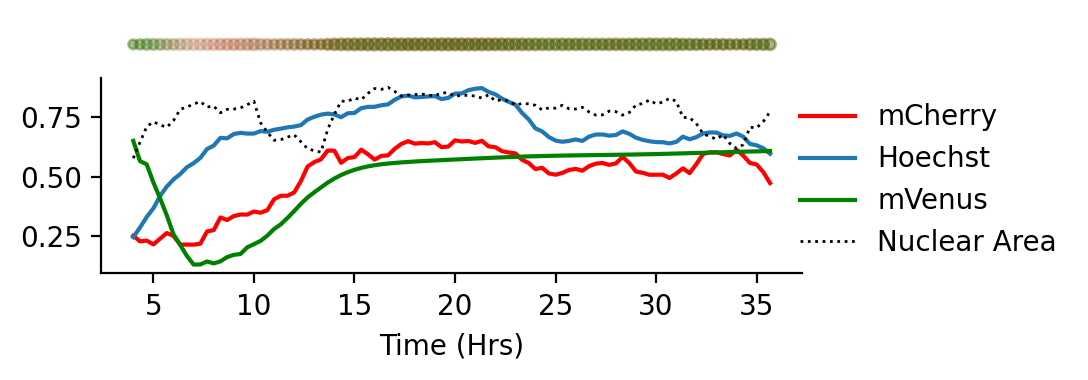

In [134]:
smooth = 10 # in frames
minsPerFrame = 20
maxTime = 36 # in hours
timeFilter = (maxTime *  60) / minsPerFrame # first 72 timepoints == 24 hours
minTrack = 24 # in hours
trackFilter = (minTrack *  60) / minsPerFrame

print(f"Minutes per Frame: {minsPerFrame}")
print(f"Max Time: {maxTime}hrs ({int(timeFilter)} frames)")
print(f"Min Track: {minTrack}hrs ({int(trackFilter)} frames)")

# filter the data
pdf = df.copy()
pdf = pdf[pdf['t'] < timeFilter]
pdf['trackLength'] = pdf.groupby('ID')['x'].count()

longTracks = pdf[pdf['trackLength'] > trackFilter]
rid = np.random.choice(longTracks.index, 1)[0]
# rid = 195
print(f"Random Track Id: {rid}")


# get the track
pdf = pdf[pdf['ID'] == rid].reset_index(drop=True)
pdf['Time'] = (pdf['t'] * minsPerFrame) / 60

c1 = 'c0_logFoldChange_total'
c2 = 'c1_logFoldChange_total'
c3 = 'c2_logFoldChange_total'

min_max_scaler = preprocessing.MinMaxScaler()

# normalize
pdf['c1'] = min_max_scaler.fit_transform(pdf[c1].to_numpy().reshape(-1, 1))
pdf['c2'] = min_max_scaler.fit_transform(pdf[c2].to_numpy().reshape(-1, 1))
pdf['c3'] = min_max_scaler.fit_transform(pdf[c3].to_numpy().reshape(-1, 1))
pdf['A'] = min_max_scaler.fit_transform(pdf['area_convex'].to_numpy().reshape(-1, 1))

# smooth
pdf['c1'] = pdf['c1'].rolling(smooth).mean()
pdf['c2'] = pdf['c2'].rolling(smooth).mean()
pdf['c3'] = pdf['c3'].rolling(smooth).mean()

pdf['A'] = pdf['A'].rolling(smooth).mean()


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2

fig, ax = plt.subplots()

ax.plot(pdf['Time'], pdf['c1'], c='r', lw=1.5,label='mCherry')
ax.plot(pdf['Time'], pdf['c2'], c='C0', lw=1.5,label='Hoechst')
ax.plot(pdf['Time'], pdf['c3'], c='g', lw=1.5,label='mVenus')
ax.plot(pdf['Time'], pdf['A'], c='k', lw=1, ls=":", label='Nuclear Area')

plt.legend()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.4,1))
ax.set_ylabel("")
ax.set_xlabel("Time (Hrs)")

sns.despine(ax=ax)


ax_divider = make_axes_locatable(ax)
ax2 = ax_divider.append_axes("top", 
                             size="25%", 
                             pad=f"5%")

ax2.scatter(pdf['Time'], [1]*len(pdf), s=pdf['A']*20, c='r', alpha=pdf['c1'].fillna(0)*0.5)
ax2.scatter(pdf['Time'], [1]*len(pdf), s=pdf['A']*20, c='g', alpha=pdf['c3'].fillna(0)*0.5)


ax2.set_yticks([])
ax2.set_xticks([])
# ax2.sharex(ax)
sns.despine(ax=ax2, bottom=True, left=True)
plt.tight_layout()

In [37]:
pdf.columns

Index(['ID', 't', 'x', 'y', 'z', 'parent', 'root', 'state', 'generation',
       'dummy', 'area_x', 'area_y', 'area_convex', 'area_filled',
       'axis_major_length', 'axis_minor_length', 'eccentricity',
       'c0_intensity_max', 'c1_intensity_max', 'c2_intensity_max',
       'c0_intensity_min', 'c1_intensity_min', 'c2_intensity_min',
       'c0_intensity_mean', 'c1_intensity_mean', 'c2_intensity_mean', 'label',
       'orientation', 'perimeter', 'solidity', 'circularity',
       'c0_logFoldChange_masked', 'c0_logFoldChange_total',
       'c1_logFoldChange_masked', 'c1_logFoldChange_total',
       'c2_logFoldChange_masked', 'c2_logFoldChange_total', 'c0_pval_masked',
       'c0_pval_total', 'c1_pval_masked', 'c1_pval_total', 'c2_pval_masked',
       'c2_pval_total', 'trackLength', 'Time', 'f1', 'f2'],
      dtype='object')

In [7]:
24 * 3

72

rid=283


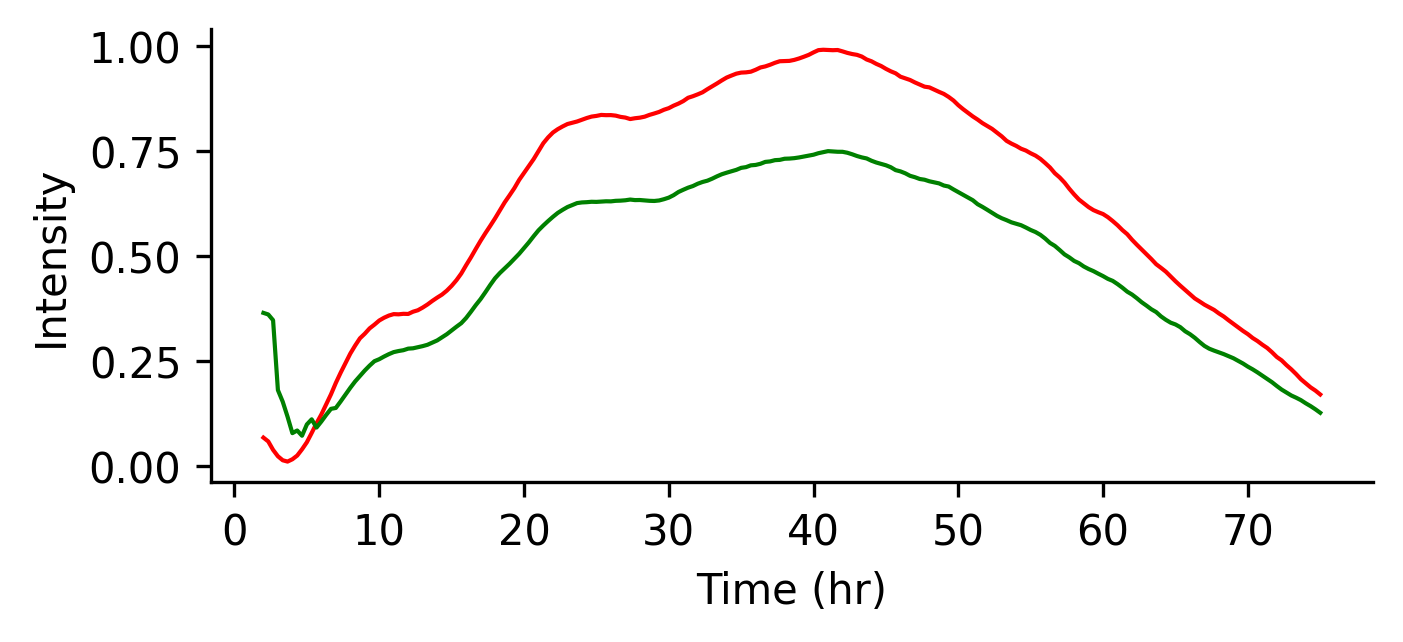

In [87]:
minT = 50
minsPerFrame = 20

field1 = 'c0_logFoldChange_total'
field2 = 'c2_logFoldChange_total'

trackLen = df.groupby('ID')['x'].count()
longTracks = trackLen[trackLen > minT]

# 
rid = np.random.choice(longTracks.index, 1)[0]
print(f"{rid=}")
pdf = df[df['ID'] == rid].reset_index(drop=True)

pdf['Time'] = (pdf['t'] * 20) / 60


min_max_scaler = preprocessing.MinMaxScaler()

# normalize
pdf['f1'] = min_max_scaler.fit_transform(pdf[field1].to_numpy().reshape(-1, 1))
pdf['f2'] = min_max_scaler.fit_transform(pdf[field2].to_numpy().reshape(-1, 1))

# smooth
pdf['f1'] = pdf['f1'].rolling(6).mean()
pdf['f2'] = pdf['f2'].rolling(6).mean()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2

sns.lineplot(data=pdf, 
             x='Time',
             y='f1',
             lw=1,
             c='r')

sns.lineplot(data=pdf, 
             x='Time',
             y='f2',
             lw=1,
             c='g')

plt.xlabel('Time (hr)')
plt.ylabel('Intensity')
sns.despine()

